In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom
from smooth import Smoother, GenericSmoother, GenericSmootherWithMemory, Memory, compute_diffs

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [8]:
test_images = [lanelines.open_image(f, convert_to_rgb=True) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [9]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

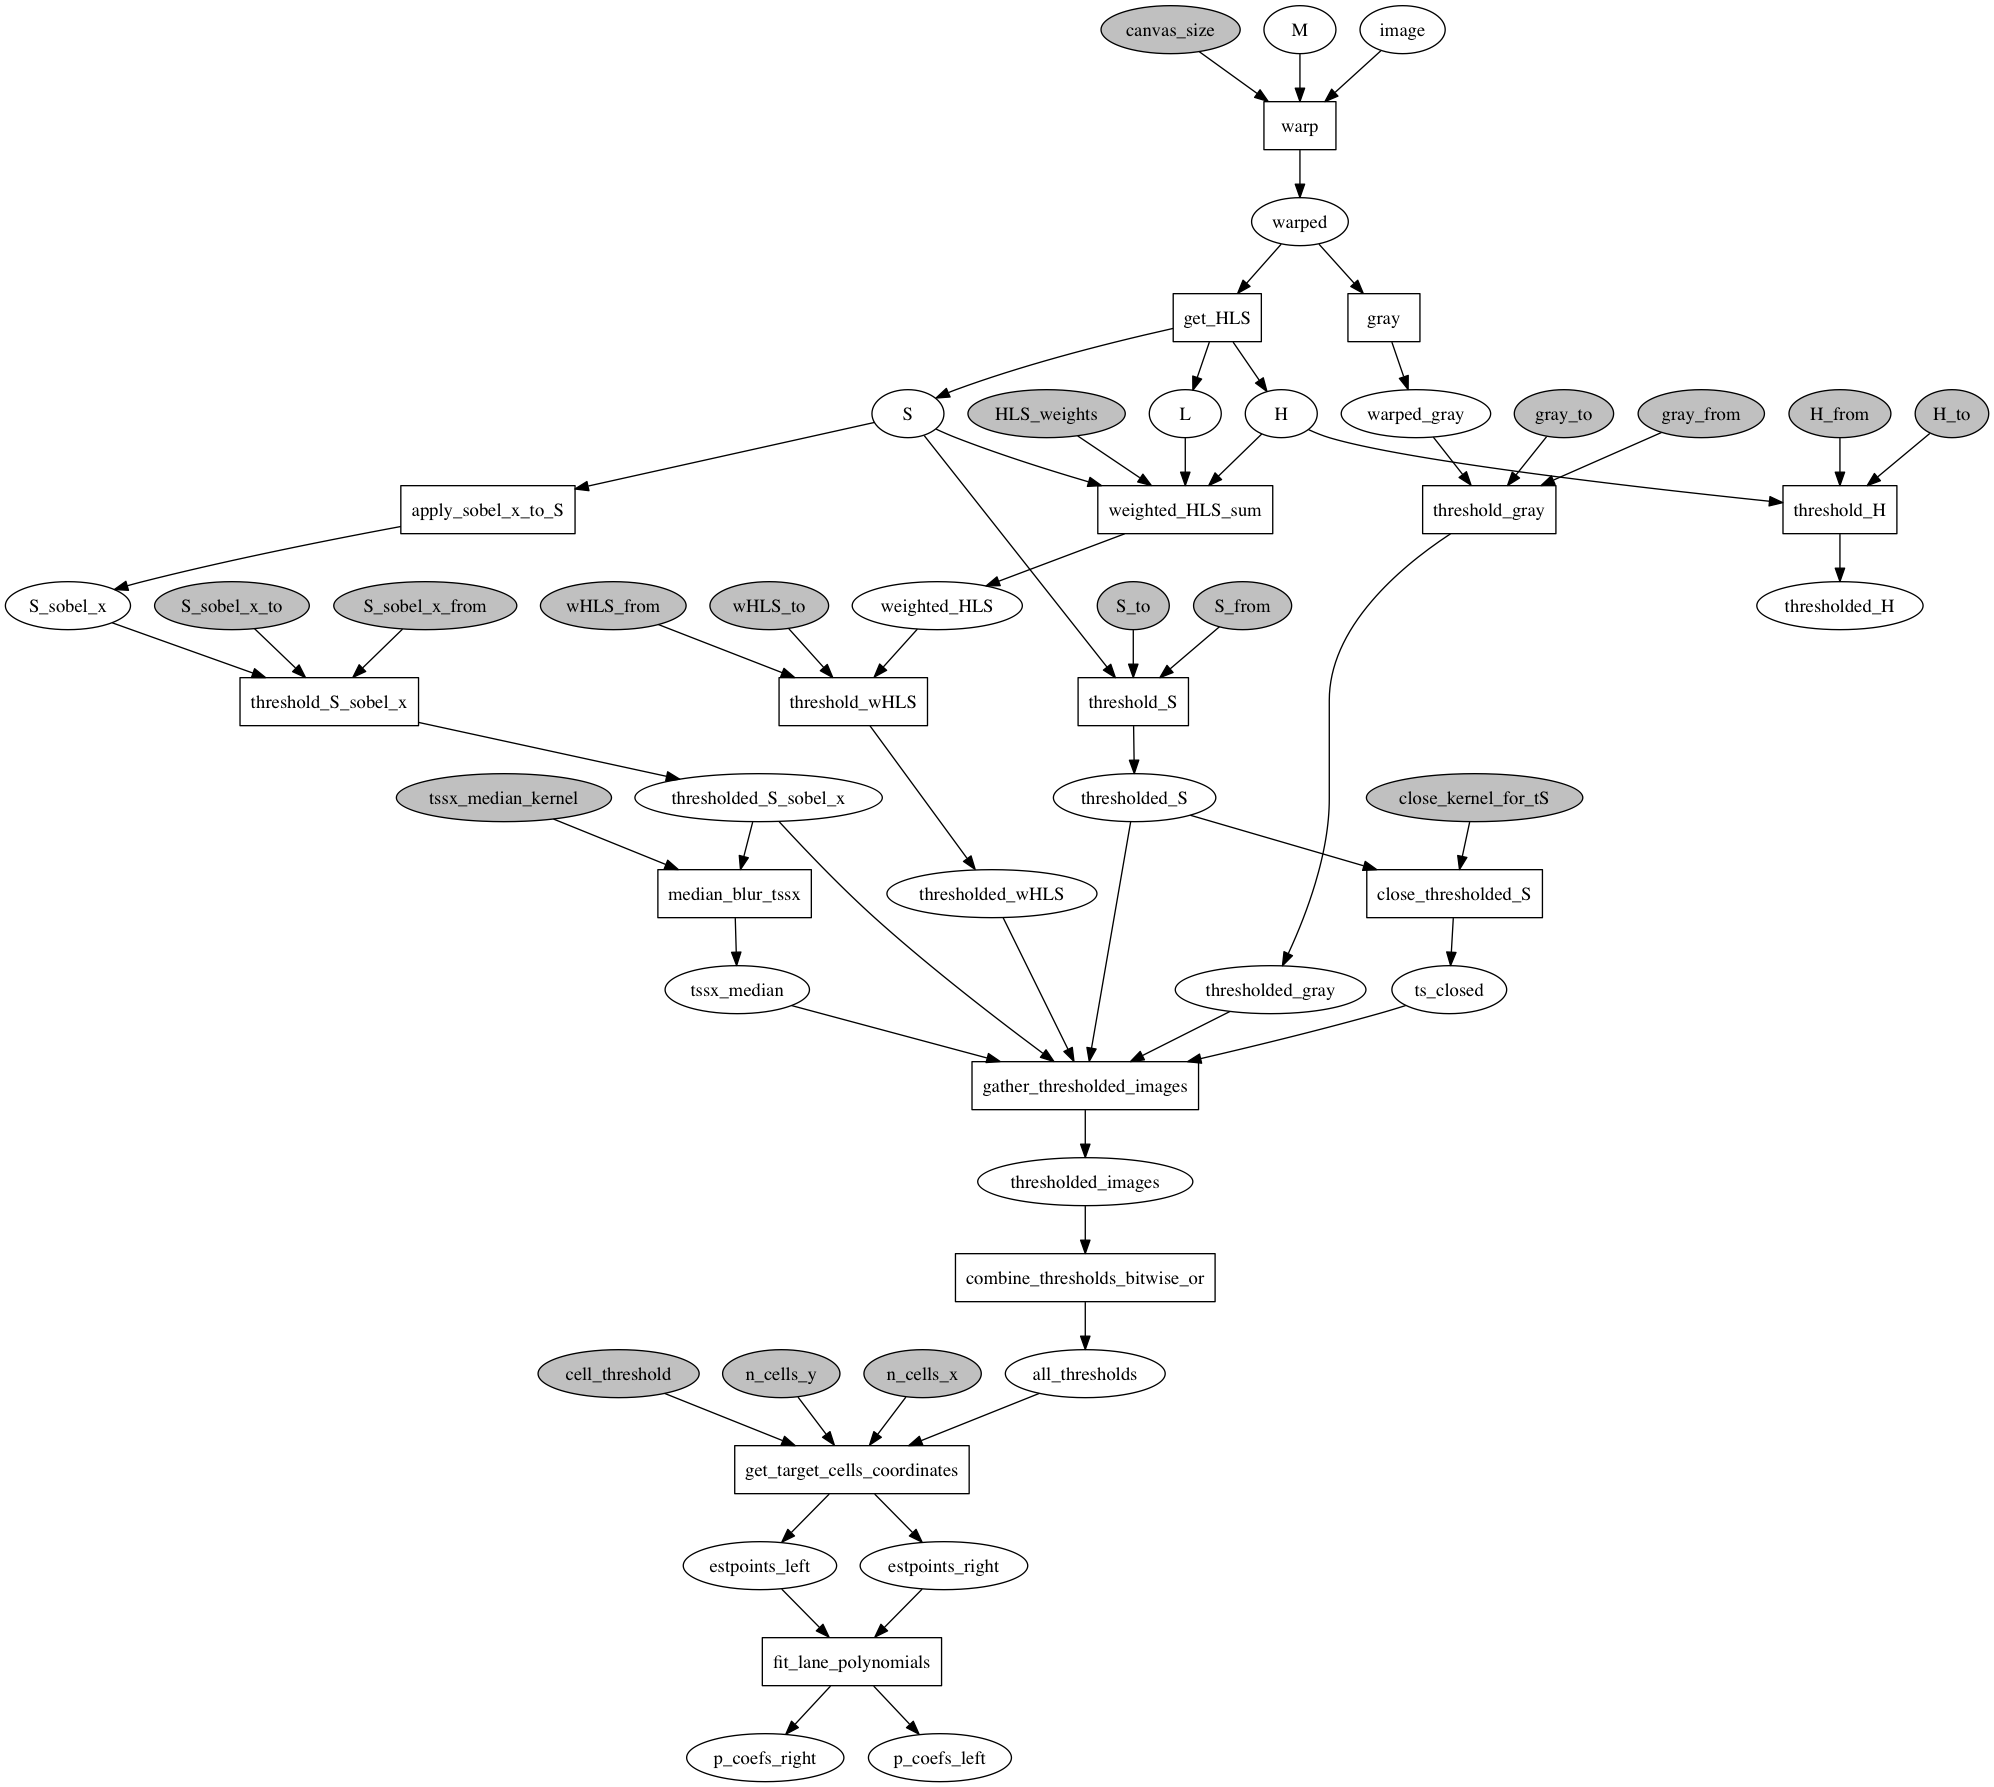

In [10]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

In [11]:
mx, my = lanelines.pixel_to_meter_ratios_custom()

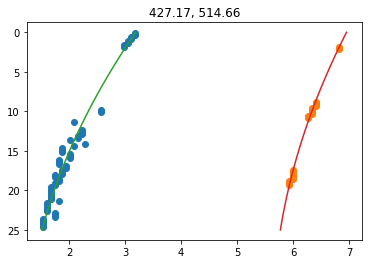

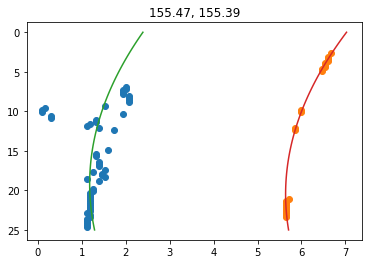

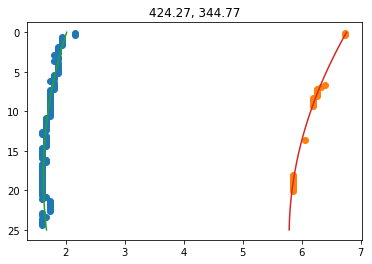

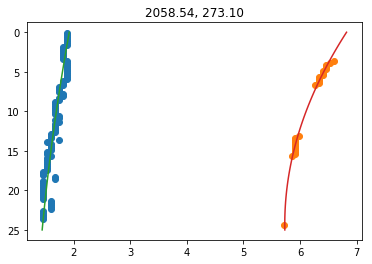

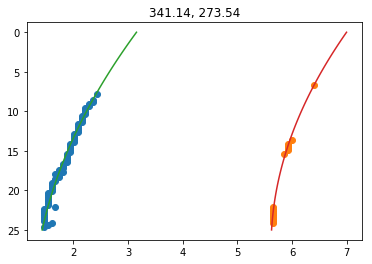

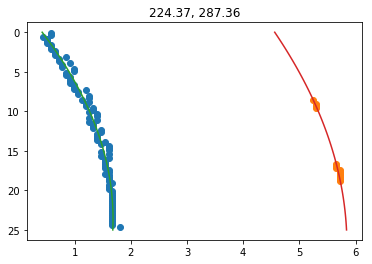

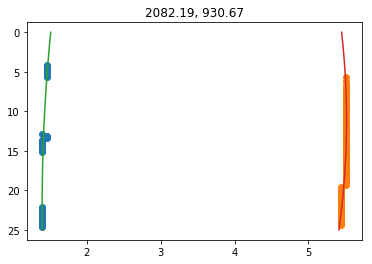

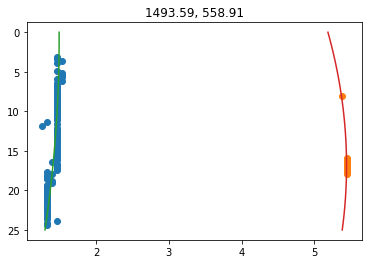

In [12]:
for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M)
    
    points_left = lanelines.pixel_points_to_meters(runner['estpoints_left'], mx, my)
    points_right = lanelines.pixel_points_to_meters(runner['estpoints_right'], mx, my)

    coefs_left, coefs_right = lanelines.fit_lane_polynomials(points_left, points_right)

    curv_left = lanelines.curvature_poly2(coefs_left, 0)
    curv_right = lanelines.curvature_poly2(coefs_right, 0)
    
    poly_left = lanelines.get_polynomial_2(coefs_left)
    poly_right = lanelines.get_polynomial_2(coefs_right)

    plotpoints_y = np.linspace(0, 25)
    plotpoints_leftx = poly_left(plotpoints_y)
    plotpoints_rightx = poly_right(plotpoints_y)
    
    plt.figure()
    plt.plot(points_left[:, 0], points_left[:, 1], 'o')
    plt.plot(points_right[:, 0], points_right[:, 1], 'o')

    plt.plot(plotpoints_leftx, plotpoints_y)
    plt.plot(plotpoints_rightx, plotpoints_y)
    
    plt.gca().invert_yaxis()
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left, curv_right))
    
    
    
